# **SENG 550 Project**
#### Develop a classifier that can predict whether a given day will be "good" or "bad" in terms of rush hour commute
+  ####*Part 1:* Read and parse the initial dataset
+  ####*Part 2:* Train and evaluate a classification model
+  ####*Part 3:* Build more classification models
+  ####*Part 5:* Conclusion

### ** Part 1: Read and parse the initial dataset **

#### ** (1a) Load and check the data **
#### The raw data is currently stored in 3 text files.  Commute time data is stored in one of these files. This is the same file you used in a previous lab.  Weather data for the duration of the commute time dataset is stored in 2 separate files - one for 2013 and one for 2014.  This data was obtained from Environment Canada.  We will start by storing the commute time data in a RDD and the weather data in 2 separate RDDs.  Each element of these RDDs is a comma separated string.  Use the [count method](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.count) to check how many data points/lines we have in each of the RDDs.  Then use the [take method](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.take) to create and print out a list of the first 2 data points in their initial string format from the commute time RDD and first 15 lines from each of the weather RDDs.

In [0]:
import os.path
baseDir = os.path.join('.')
inputPath1 = os.path.join('/FileStore/tables/deerfoot.csv')
inputPath2 = os.path.join('/FileStore/tables/eng_daily_01012013_12312013.csv')
inputPath3 = os.path.join('/FileStore/tables/eng_daily_01012014_12312014.csv')
fileName1 = os.path.join(baseDir, inputPath1)
fileName2 = os.path.join(baseDir, inputPath2)
fileName3 = os.path.join(baseDir, inputPath3)

deerfootRDD = sc.textFile(fileName1, 8)
weather2013RDD = sc.textFile(fileName2,8)
weather2014RDD = sc.textFile(fileName3,8)

In [0]:
numPoints = deerfootRDD.count()
print (numPoints)
samplePoints = deerfootRDD.take(1)
print (samplePoints)
num2013WeatherLines = weather2013RDD.count()
num2014WeatherLines = weather2014RDD.count()
print (num2013WeatherLines)
print (num2014WeatherLines)
sample2013WeatherLines = weather2013RDD.take(30)
sample2014WeatherLines = weather2014RDD.take(30)
print (sample2013WeatherLines)
print (sample2014WeatherLines)

202
['21/09/2013,Saturday,34,34,34,34,35,34,35,36,38,36,36,35,35,35,35,35,36,34,34,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2']
391
391
['"Station Name","CALGARY INTL A"', '"Province","ALBERTA"', '"Latitude","51.12"', '"Longitude","-114.01"', '"Elevation","1099.10"', '"Climate Identifier","3031092"', '"WMO Identifier","71877"', '"TC Identifier","YYC"', '', '"Legend"', '"A","Accumulated"', '"C","Precipitation occurred, amount uncertain"', '"E","Estimated"', '"F","Accumulated and estimated"', '"L","Precipitation may or may not have occurred"', '"M","Missing"', '"N","Temperature missing but known to be > 0"', '"S","More than one occurrence"', '"T","Trace"', '"Y","Temperature missing but known to be < 0"', '"[empty]","No data available"', '"^","The value displayed is based on incomplete data"', '"�","Data for this day has undergone only preliminary quality checking"', '"�","Partner data that is not subject to review by the National Climate Archives"', '', '"Date/Time","Year","Mont

#### ** (1b) Preprocessing RDDs - extracting desired fields from commute time data **
####We need to pre-process the RDDs before we can use them for training a regression model.  For this exercise, we will consider predicting the commute time at 5 PM in the evening when traffic is typically heavy.  As a result we won't be using all the fields in the 'deerfootRDD'.  Specifically, we will only be using the following fields - Date (field 0), Weekday (fiedl 1), Commute time per time segment from 7am to 10pm(field 4 to 7), Commute time per time segment from 3pm to 6pm(field 13 to 16), Number of Accidents per time segment from 7am to 10am (field 22 to 26), Number of Accidents per time segment from 3pm to 6pm (field 31 to 35).

In [0]:
def extractFields(deerfootRDDRecord):
    """Creates a key-value pair consisting of the Date field as the key and the the tuple 
    (Day, Weekday, Sum of commute time from 7am to 10am, Sum of commute time from 3pm to 5pm,  Number of Accidents per time segment from 6am to 10am,  Number of Accidents per time segment from 2pm to 5pm) as the value

    Args:
        deerfootRDDRecord : a comma separated string consisting of all fields in the data set.

    Returns:
        extracted record: key-value pair as detailed above
    """
    fieldsList = deerfootRDDRecord.split(',')
    rushHourSum1 = sum(list(map(int,fieldsList[4:7])))
    incidentSum1 = sum(list(map(int,fieldsList[22:26])))
    
    rushHourSum2 = sum(list(map(int,fieldsList[13:16])))
    incidentSum2 = sum(list(map(int,fieldsList[31:35])))
    return (fieldsList[0],(fieldsList[1],rushHourSum1,rushHourSum2,incidentSum1,incidentSum2))
   
deerfootPairRDD = deerfootRDD.map(extractFields)
print(deerfootPairRDD.take(4))

[('21/09/2013', ('Saturday', 103, 105, 2, 0)), ('22/09/2013', ('Sunday', 102, 104, 1, 0)), ('23/09/2013', ('Monday', 129, 129, 0, 0)), ('24/09/2013', ('Tuesday', 136, 131, 2, 2))]


#### ** (1c) Preprocessing RDDs - extracting desired lines from weather data **
####If you notice the output of the weather files the first few lines don't contain the data - they contain metadata and column labels.  These need to be removed.  Use a Spark transformation to discard unwanted metadata and header information.  Hint: You can see whether a unicode string string1 contains another string in variable string2 using 'u'string1' in string2'

In [0]:
def filterLines(weatherRDDRecord):
    """ Skips lines with metadata and label information
    Args:
        weatherRDDRecord : a line from the weather file.

    Returns:
        True - if line is not metadata/label; False otherwise
    """
    fieldsList = weatherRDDRecord.split(',')
    if u'2013' in fieldsList[0] or u'2014' in fieldsList[0]:
        return True 
    else:
        return False

filteredWeather2013RDD = weather2013RDD.filter(filterLines)
filteredWeather2014RDD = weather2014RDD.filter(filterLines)
print(filteredWeather2013RDD.take(5))
print(filteredWeather2014RDD.take(5))

['"2013-01-01","2013","01","01","�","1.2","","-8.9","","-3.9","","21.9","","0.0","","0.0","T","0.0","","0.0","T","4","","33","","48",""', '"2013-01-02","2013","01","02","�","5.8","","-10.9","","-2.6","","20.6","","0.0","","0.0","","0.0","","0.0","","3","","29","","41",""', '"2013-01-03","2013","01","03","�","8.8","","-8.8","","0.0","","18.0","","0.0","","0.0","","0.0","","0.0","","2","","28","","52",""', '"2013-01-04","2013","01","04","�","2.9","","-11.2","","-4.2","","22.2","","0.0","","0.0","","0.0","","0.0","","2","","26","","63",""', '"2013-01-05","2013","01","05","�","4.8","","-10.0","","-2.6","","20.6","","0.0","","0.0","","0.0","","0.0","","1","","27","","41",""']
['"2014-01-01","2014","01","01","�","-0.6","","-9.7","","-5.2","","23.2","","0.0","","0.0","","1.0","","0.8","","9","","","","<31",""', '"2014-01-02","2014","01","02","�","8.5","","-10.0","","-0.8","","18.8","","0.0","","0.0","","0.0","","0.0","","11","","27","","52",""', '"2014-01-03","2014","01","03","�","3.0","","-1

#### ** (1d) Preprocessing RDDs - Fixing date format inconsistency**
####If you compare the Date fields of the commute time and weather files you will notice that they are in different formats.  While the date in the commute time file is in the format "day/month/year" it is in the format "year-month-day".  We need to fix things so that the weather data has the same date format as the commute time data. (It is very typical to deal with such annoyances while developing models from different data sources). Use a Spark transformation that constructs a pairRDD whose key is the date and whose value is a tuple containing the rest of the columns of the weather data.  Note, you need to construct 2 pairRDDs, one for 2013 and another for 2014.  Also, as mentioned previously, you need to fix the date formatting such that it matches the formatting in the commute time data.

In [0]:
def fixDate(weatherRDDRecord):
    """Creates a key-value pair - key is date in format 'day/month/year' value - a comma separated string containing other fields of the record
    Args:
        weatherRDDRecord : a comma separated string consisting of all fields in the weather data set.

    Returns:
        extracted record: key-value pair as detailed above
    """
    fieldList = weatherRDDRecord.split(',')
    year,month,day = fieldList[0].split('-')
    return (day[:-1]+'/'+month+'/'+year[1:], ', '.join(fieldList[1:]))
   
fixedWeather2013RDD = filteredWeather2013RDD.map(fixDate)
fixedWeather2014RDD = filteredWeather2014RDD.map(fixDate)
print(fixedWeather2013RDD.take(2))
print(fixedWeather2014RDD.take(2))

[('01/01/2013', '"2013", "01", "01", "�", "1.2", "", "-8.9", "", "-3.9", "", "21.9", "", "0.0", "", "0.0", "T", "0.0", "", "0.0", "T", "4", "", "33", "", "48", ""'), ('02/01/2013', '"2013", "01", "02", "�", "5.8", "", "-10.9", "", "-2.6", "", "20.6", "", "0.0", "", "0.0", "", "0.0", "", "0.0", "", "3", "", "29", "", "41", ""')]
[('01/01/2014', '"2014", "01", "01", "�", "-0.6", "", "-9.7", "", "-5.2", "", "23.2", "", "0.0", "", "0.0", "", "1.0", "", "0.8", "", "9", "", "", "", "<31", ""'), ('02/01/2014', '"2014", "01", "02", "�", "8.5", "", "-10.0", "", "-0.8", "", "18.8", "", "0.0", "", "0.0", "", "0.0", "", "0.0", "", "11", "", "27", "", "52", ""')]


#### ** (1e) Extracting the desired days from weather data**
####Commute times have been recorded for the period September 21, 2013 to April 10, 2014.  We need to consider only the weather data for this period while building the linear regression model.  Use a Spark transformation to append the 'fixedWeather2014' RDD to the 'fixedWeather2013' RDD to create a new RDD.  Then, use another Spark transformation to filter out days before September 21, 2013 and days after April 10, 2014. We will also only consider using the number of accidents and the "Snow on the ground" fields of the combined dataset while building our predictive model.  While other fields, e.g., temperature, might also impact commute times, we will ignore them for the sake of simplicity.  As a result, we need to filter out the unwanted fields.  Use appropriate Spark transformations to produce an RDD whose each record has the format "commute time, number of accidents, snow on the ground". If the "snow on the ground" field is "", i.e., data was not logged that day, then assume that it is "0", i.e., assume that day had 0 snow on the ground.

In [0]:
def filterDates(weatherRDDRecord):
    """Skips records before September 21, 2013 and after April 10, 2014
    Args:
        weatherRDDRecord : key-value record where key is date and value is comma separated string of other weather fields

    Returns:
        True if key is in the desired period; False otherwise
    """
    value = weatherRDDRecord[1]
    fields = value.split(",")
    validMonths2013 = [u'"09"',u'"10"',u'"11"',u'"12"']
    validSeptemberDays2013 = [u'"21"',u'"22"',u'"23"',u'"24"',u'"25"',u'"26"',u'"27"',u'"28"',u'"29"',u'"30"']
    validAprilDays2014=[u'"01"',u'"02"',u'"03"',u'"04"',u'"05"',u'"06"',u'"07"',u'"08"',u'"09"',u'"10"']
    validMonths2014=[u'"01"',u'"02"',u'"03"',u'"04"']
    if fields[0]==u'"2013"':      
        if fields[1].strip() in validMonths2013:
            if fields[1].strip()==u'"09"':
                if fields[2].strip() in validSeptemberDays2013:
                    return True
                else:
                    return False
            else:
                return True
        else:
            return False    
    else:
        if fields[1].strip() in validMonths2014:
            if fields[1].strip()==u'"04"':
                if fields[2].strip() in validAprilDays2014:
                    return True
                else:
                    return False
            else:
                return True
        else:
            return False

aggregateWeatherRDD = fixedWeather2013RDD.union(fixedWeather2014RDD)  
print(aggregateWeatherRDD.count())
desiredWeatherRDD = aggregateWeatherRDD.filter(filterDates)
print(desiredWeatherRDD.count())# Should output 202
print(desiredWeatherRDD.take(1))

def extractSnowOnGround(weatherDataPoint):
    dataList = weatherDataPoint[1].split(",")
    snowG = dataList[20]
    if snowG.strip()==u'""':
        snowG='0'
    else:
        snowG=snowG[2:-1]
    return (weatherDataPoint[0], snowG)

desiredWeatherRDD = desiredWeatherRDD.map(extractSnowOnGround)
print(desiredWeatherRDD.take(43))

730
202
[('21/09/2013', '"2013", "09", "21", "�", "24.0", "", "5.5", "", "14.8", "", "3.2", "", "0.0", "", "0.0", "", "0.0", "", "0.0", "", "", "", "21", "", "63", ""')]
[('21/09/2013', '0'), ('22/09/2013', '0'), ('23/09/2013', '0'), ('24/09/2013', '0'), ('25/09/2013', '0'), ('26/09/2013', '0'), ('27/09/2013', '0'), ('28/09/2013', '0'), ('29/09/2013', '0'), ('30/09/2013', '0'), ('01/10/2013', '0'), ('02/10/2013', '0'), ('03/10/2013', '0'), ('04/10/2013', '0'), ('05/10/2013', '0'), ('06/10/2013', '0'), ('07/10/2013', '0'), ('08/10/2013', '0'), ('09/10/2013', '0'), ('10/10/2013', '0'), ('11/10/2013', '0'), ('12/10/2013', '0'), ('13/10/2013', '0'), ('14/10/2013', '0'), ('15/10/2013', '0'), ('16/10/2013', '0'), ('17/10/2013', '0'), ('18/10/2013', '0'), ('19/10/2013', '0'), ('20/10/2013', '0'), ('21/10/2013', '0'), ('22/10/2013', '0'), ('23/10/2013', '0'), ('24/10/2013', '0'), ('25/10/2013', '0'), ('26/10/2013', '0'), ('27/10/2013', '4'), ('28/10/2013', '4'), ('29/10/2013', '4'), ('30/10/20

#### ** (1e) Merging commute time and weather data**
####We have to merge the commute time RDD 'deerfootPairRDD' and the weather RDD 'desiredWeatherRDD'.  Use an appropriate Spark transformation that uses the common key date key in both RDDs.  Print the number of elements and the first 5 elements of the resulting RDD.

In [0]:
#Join by date
combinedPairRDD = deerfootPairRDD.join(desiredWeatherRDD)
print(combinedPairRDD.count())
print(combinedPairRDD.take(43))

202
[('30/09/2013', (('Monday', 128, 125, 1, 1), '0')), ('11/11/2013', (('Monday', 109, 116, 0, 0), '3')), ('05/12/2013', (('Thursday', 136, 133, 0, 2), '13')), ('25/12/2013', (('Wednesday', 109, 105, 0, 0), '12')), ('07/01/2014', (('Tuesday', 119, 129, 0, 4), '8')), ('11/03/2014', (('Tuesday', 120, 128, 0, 2), '0')), ('03/04/2014', (('Thursday', 113, 118, 1, 4), '5')), ('09/04/2014', (('Wednesday', 114, 122, 0, 5), '0')), ('12/10/2013', (('Saturday', 103, 105, 0, 0), '0')), ('31/10/2013', (('Thursday', 121, 159, 0, 3), '1')), ('13/11/2013', (('Wednesday', 118, 136, 0, 1), '1')), ('14/11/2013', (('Thursday', 118, 139, 0, 3), '1')), ('07/12/2013', (('Saturday', 105, 108, 1, 0), '12')), ('01/02/2014', (('Saturday', 102, 103, 0, 0), '3')), ('16/02/2014', (('Sunday', 102, 102, 0, 0), '1')), ('17/03/2014', (('Monday', 116, 113, 0, 2), '0')), ('08/04/2014', (('Tuesday', 112, 129, 0, 4), '0')), ('22/09/2013', (('Sunday', 102, 104, 1, 0), '0')), ('21/10/2013', (('Monday', 118, 129, 0, 0), '0')

#### ** (1f) Filter out weekends and remove unwanted data fields**
#### Predicting commute times is more crucial for weekdays than for weekends, which have very light traffic.  So, we will exclude saturdays and sundays from the combined dataset. We will also keep only list of

In [0]:
def filterWeekends(combinedPairRDDRecord):
    """Skips records corresponding to Saturdays and Sundays
    Args:
        combinedPairRDDRecord : key-value record where key is date and value is a tuple containing comma-separated string values from deerfootPairRDD and desiredWeatherRDD 

    Returns:
        True if key is in the desired period; False otherwise
    """
    value=combinedPairRDDRecord[1]
    #print value[0][0]
    if value[0][0]==u'Saturday' or value[0][0]==u'Sunday':
        return False
    else:
        return True

combinedPairRDDWeekdays = combinedPairRDD.filter(filterWeekends)
print(combinedPairRDDWeekdays.take(5))
# Calculate mean for 2 different rush hours(7am-10am, 3pm-5pm)
# The mean values are used to determin a good/bad day for rush hour commute time. If at least one of the rush hours is above mean, then the day is a bad day, else it's a good day.
timeListRDD1 = combinedPairRDDWeekdays.map(lambda x: int(x[1][0][1]))
timeListRDD2 = combinedPairRDDWeekdays.map(lambda x: int(x[1][0][2]))
totalMorningSum = timeListRDD1.sum()
numDay = timeListRDD1.count()
totalMorningMean = totalMorningSum/numDay
totalAfternoonSum = timeListRDD2.sum()
totalAfternoonMean = totalAfternoonSum/numDay
print(totalMorningMean,totalAfternoonMean)
#Simplify data to 2 rdds:
#morningRDD (Good/Bad commute time label, Number of Accidents per time segment from 6am to 10am, Snow on the ground in cm)
#afternoonRDD (Good/Bad commute time label, Number of Accidents per time segment from 2pm to 5pm, Snow on the ground in cm)
morningRDD = combinedPairRDDWeekdays.map(lambda x: (1,x[1][0][3],int(x[1][1])) if x[1][0][1] <= totalMorningMean else  (0,x[1][0][3],int(x[1][1])))
afternoonRDD = combinedPairRDDWeekdays.map(lambda x: (1,x[1][0][4],int(x[1][1])) if  x[1][0][2] <= totalAfternoonMean else  (0,x[1][0][4],int(x[1][1])))
print(morningRDD.count())
print(morningRDD.take(5))
print(afternoonRDD.count())
print(afternoonRDD.take(5))
#Now put morningRDD and afternoonRDD together
#finalRDD (Good/Bad commute time label, Number of Accidents within 4 time segments, Snow on the ground in cm)
finalRDD = morningRDD.union(afternoonRDD)
print(finalRDD.count())
print(finalRDD.take(5))

[('30/09/2013', (('Monday', 128, 125, 1, 1), '0')), ('11/11/2013', (('Monday', 109, 116, 0, 0), '3')), ('05/12/2013', (('Thursday', 136, 133, 0, 2), '13')), ('25/12/2013', (('Wednesday', 109, 105, 0, 0), '12')), ('07/01/2014', (('Tuesday', 119, 129, 0, 4), '8'))]
122.22916666666667 129.63888888888889
144
[(0, 1, 0), (1, 0, 3), (0, 0, 13), (1, 0, 12), (1, 0, 8)]
144
[(1, 1, 0), (1, 0, 3), (0, 2, 13), (1, 0, 12), (1, 4, 8)]
288
[(0, 1, 0), (1, 0, 3), (0, 0, 13), (1, 0, 12), (1, 0, 8)]


#### ** (1g) Using `Dataframe` **
 We'll use dataframes to train our models

In [0]:
from pyspark.ml.linalg import DenseVector
test = finalRDD.map(lambda x: (x[0], DenseVector(x[1:])))
df = spark.createDataFrame(test, ["label", "features"])
df.show()

+-----+----------+
|label|  features|
+-----+----------+
|    0| [1.0,0.0]|
|    1| [0.0,3.0]|
|    0|[0.0,13.0]|
|    1|[0.0,12.0]|
|    1| [0.0,8.0]|
|    1| [0.0,0.0]|
|    1| [1.0,5.0]|
|    1| [0.0,0.0]|
|    1| [0.0,1.0]|
|    1| [0.0,1.0]|
|    1| [0.0,1.0]|
|    1| [0.0,0.0]|
|    1| [0.0,0.0]|
|    1| [0.0,0.0]|
|    1| [1.0,3.0]|
|    1| [0.0,3.0]|
|    1| [0.0,0.0]|
|    1| [0.0,0.0]|
|    1| [1.0,0.0]|
|    1| [1.0,1.0]|
+-----+----------+
only showing top 20 rows



#### **(1h) Feature scaling **####
we want to scale and normalize our data to prevent errors in some machine learning algorithms.

In [0]:
from pyspark.ml.feature import StandardScaler

# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

# Fit the DataFrame to the scaler
scaler = standardScaler.fit(df)

# Transform the data in `df` with the scaler
scaled_df = scaler.transform(df)

# Inspect the result
scaled_df.show()

+-----+----------+--------------------+
|label|  features|     features_scaled|
+-----+----------+--------------------+
|    0| [1.0,0.0]|[0.61605179560519...|
|    1| [0.0,3.0]|[0.0,0.5475004829...|
|    0|[0.0,13.0]|[0.0,2.3725020928...|
|    1|[0.0,12.0]|[0.0,2.1900019318...|
|    1| [0.0,8.0]|[0.0,1.4600012878...|
|    1| [0.0,0.0]|           [0.0,0.0]|
|    1| [1.0,5.0]|[0.61605179560519...|
|    1| [0.0,0.0]|           [0.0,0.0]|
|    1| [0.0,1.0]|[0.0,0.1825001609...|
|    1| [0.0,1.0]|[0.0,0.1825001609...|
|    1| [0.0,1.0]|[0.0,0.1825001609...|
|    1| [0.0,0.0]|           [0.0,0.0]|
|    1| [0.0,0.0]|           [0.0,0.0]|
|    1| [0.0,0.0]|           [0.0,0.0]|
|    1| [1.0,3.0]|[0.61605179560519...|
|    1| [0.0,3.0]|[0.0,0.5475004829...|
|    1| [0.0,0.0]|           [0.0,0.0]|
|    1| [0.0,0.0]|           [0.0,0.0]|
|    1| [1.0,0.0]|[0.61605179560519...|
|    1| [1.0,1.0]|[0.61605179560519...|
+-----+----------+--------------------+
only showing top 20 rows



#### ** (1i) Training and validation sets **
#### We're almost done parsing our dataset, and our final task involves split it into a training set and a validation set. Use the [randomSplit method](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.randomSplit) with the specified weights and seed to create RDDs storing each of these datasets. Next, cache each of these RDDs, as we will be accessing them multiple times in the remainder of this lab. Finally, compute the size of each dataset and verify that the sum of their sizes equals the value computed in Part (1f).

In [0]:
train, test = scaled_df.randomSplit([0.7, 0.3], seed = 812)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 203
Test Dataset Count: 85


### ** Part 2: Train and evaluate a classification model  **

####2(a) Logistic Regression Model with default regularization parameter(0)

In [0]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features_scaled', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)
# Print the coefficients and intercept for logistic regression
print("Weight Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))
print(lrModel.getRegParam())

Weight Coefficients: [-0.40116447989835724,-0.5185548671772072]
Intercept: 1.19127791694411
0.0


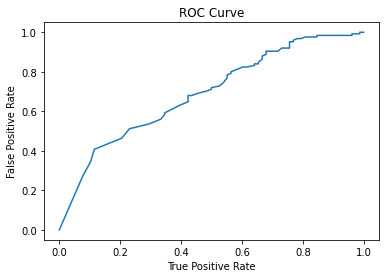

Training set areaUnderROC: 0.6906666666666669
Accuracy: 0.6551724137931034
Precision[0,1]: [0.5869565217391305, 0.6751592356687898]
Recall[0,1]: [0.34615384615384615, 0.848]


In [0]:
import matplotlib.pyplot as plt
import numpy as np
#Summarize the model over the training set, we can also obtain the receiver-operating characteristic and areaUnderROC.
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))
print("Accuracy: "+ str(trainingSummary.accuracy))
print("Precision[0,1]: "+ str(trainingSummary.precisionByLabel))
print("Recall[0,1]: "+ str(trainingSummary.recallByLabel))

In [0]:
trainingSummary.predictions.show()

+-----+----------+--------------------+--------------------+--------------------+----------+
|label|  features|     features_scaled|       rawPrediction|         probability|prediction|
+-----+----------+--------------------+--------------------+--------------------+----------+
|  1.0| [0.0,0.0]|           [0.0,0.0]|[-1.1912779169441...|[0.23303045925494...|       1.0|
|  1.0| [0.0,0.0]|           [0.0,0.0]|[-1.1912779169441...|[0.23303045925494...|       1.0|
|  1.0| [0.0,3.0]|[0.0,0.5475004829...|[-0.9073688767226...|[0.28753854805140...|       1.0|
|  1.0|[0.0,12.0]|[0.0,2.1900019318...|[-0.0556417560583...|[0.48609314877371...|       1.0|
|  1.0| [0.0,0.0]|           [0.0,0.0]|[-1.1912779169441...|[0.23303045925494...|       1.0|
|  1.0| [0.0,0.0]|           [0.0,0.0]|[-1.1912779169441...|[0.23303045925494...|       1.0|
|  1.0| [0.0,1.0]|[0.0,0.1825001609...|[-1.0966415702036...|[0.25036969173202...|       1.0|
|  1.0| [0.0,1.0]|[0.0,0.1825001609...|[-1.0966415702036...|[0.2503696

In [0]:
#Prediction on test dataset.
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Create both evaluators
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName='areaUnderROC')

# Make predicitons
predictionAndTarget = lrModel.transform(test).select("label", "prediction")

# Get metrics
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(predictionAndTarget)
print("Accuracy: "+str(acc)+", Weighted Precision: "+str(weightedPrecision)+", Weighted Recall: "+ str(weightedRecall)+", Area Under ROC: "+str(auc) )

Accuracy: 0.7058823529411765, Weighted Precision: 0.7078944253757842, Weighted Recall: 0.7058823529411765, Area Under ROC: 0.6242532855436081


####2(b)Try different hyperparameters
####We want to see how the hyperparameter effects our result, we will use TrainValidationSplit to find the best hyperparameters. That mean we will use 70% of our training data and use the other 30% of tarning data as validation data to run models with different regularization parameters.Then we will use the model wil the best result on the train/validation data to run against the test data to see how would our model change.

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.classification import LogisticRegression

lrt = LogisticRegression(featuresCol = 'features_scaled', labelCol = 'label')

# We use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using
# the evaluator.
paramGrid = ParamGridBuilder()\
    .addGrid(lrt.regParam, [0, 1, 10]) \
    .addGrid(lrt.maxIter, [1, 10]) \
    .addGrid(lrt.threshold, [0.3, 0.5, 0.7]) \
    .build()

# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(estimator=lrt,
                           estimatorParamMaps=paramGrid,
                           evaluator=BinaryClassificationEvaluator(),
                           # 70% of the 'train' data will be used for training, 30% for validation.
                           trainRatio=0.7)

#tvs should have the best hyperparameters now.
model = tvs.fit(train)

# Make predicitons
predictionAndTarget = model.transform(test).select("label", "prediction")

# Get metrics
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(predictionAndTarget)
print("Accuracy: "+str(acc)+", Weighted Precision: "+str(weightedPrecision)+", Weighted Recall: "+ str(weightedRecall)+", Area Under ROC: "+str(auc) )

/databricks/spark/python/pyspark/ml/util.py:839: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
  warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)
Accuracy: 0.6352941176470588, Weighted Precision: 0.403598615916955, Weighted Recall: 0.6352941176470588, Area Under ROC: 0.5


####As we can see, the new logistic regression model with the best parameters doesn't defeat our initial logistic regression model.

###Part 3: Other Models

####3(a) Random Forest

In [0]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features_scaled', labelCol = 'label', maxDepth=10, maxBins=32,numTrees=20, impurity='gini', featureSubsetStrategy='auto')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('label', 'features_scaled', 'rawPrediction', 'prediction', 'probability').show(25)

+-----+--------------------+--------------------+----------+--------------------+
|label|     features_scaled|       rawPrediction|prediction|         probability|
+-----+--------------------+--------------------+----------+--------------------+
|    0|[0.0,2.3725020928...|[1.50308857808857...|       1.0|[0.07515442890442...|
|    0|[0.61605179560519...|[10.5717517555954...|       0.0|[0.52858758777977...|
|    1|[0.0,1.4600012878...|[11.8495322848981...|       0.0|[0.59247661424490...|
|    1|[0.61605179560519...|[8.6,11.400000000...|       1.0|[0.43,0.570000000...|
|    1|[0.0,0.1825001609...|[2.94831068945118...|       1.0|[0.14741553447255...|
|    1|           [0.0,0.0]|[2.67848310324428...|       1.0|[0.13392415516221...|
|    1|           [0.0,0.0]|[2.67848310324428...|       1.0|[0.13392415516221...|
|    0|[0.0,1.6425014488...|[8.19365079365079...|       1.0|[0.40968253968253...|
|    0|[0.61605179560519...|[11.8704100247578...|       0.0|[0.59352050123789...|
|    1|[0.0,0.73

In [0]:
# Make predicitons
predictionAndTarget = rfModel.transform(test).select("label", "prediction")

# Get metrics
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(predictionAndTarget)
print("Accuracy: "+str(acc)+", Weighted Precision: "+str(weightedPrecision)+", Weighted Recall: "+ str(weightedRecall)+", Area Under ROC: "+str(auc) )

Accuracy: 0.5647058823529412, Weighted Precision: 0.5676956159822419, Weighted Recall: 0.5647058823529412, Area Under ROC: 0.5337514934289127


####3(b) Neural Network

In [0]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

mlpc=MultilayerPerceptronClassifier( featuresCol='features_scaled',labelCol='label',layers = [2,10,10,10,2], maxIter=20,blockSize=8,seed=7,solver='gd')
ann = mlpc.fit(train)

# Make predicitons
predictionAndTarget = ann.transform(test).select("label", "prediction")

# Get metrics
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(predictionAndTarget)
print("Accuracy: "+str(acc)+", Weighted Precision: "+str(weightedPrecision)+", Weighted Recall: "+ str(weightedRecall)+", Area Under ROC: "+str(auc) )

Accuracy: 0.6352941176470588, Weighted Precision: 0.403598615916955, Weighted Recall: 0.6352941176470588, Area Under ROC: 0.5


#### 3(c) Naive Bayes

In [0]:
from pyspark.ml.classification import NaiveBayes 

nb = NaiveBayes(modelType='multinomial')
nbmodel = nb.fit(train)
# Make predicitons
predictionAndTarget = nbmodel.transform(test).select("label", "prediction")

# Get metrics
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(predictionAndTarget)
print("Accuracy: "+str(acc)+", Weighted Precision: "+str(weightedPrecision)+", Weighted Recall: "+ str(weightedRecall)+", Area Under ROC: "+str(auc) )

Accuracy: 0.5882352941176471, Weighted Precision: 0.5075294117647059, Weighted Recall: 0.5882352941176471, Area Under ROC: 0.48357228195937874


###Conclusion

Our current best modelis the Logistic Regression model.And our optimizations on the model did not improve the result much. A 70% Area Under ROC is not a very good result, and we found 2 main reasons for this. Reason 1 Small Dataset: Our data source deerfoot.csv only contains commute time and accidents data for 202 days, and 144 weekdays after removing the weekends. If we have more data, we can do more data preprocessing such as categorize data by season, which may be helpful to improve the performance of models. Reason 2 Irrelevant Features: we use the number of accidents within 4 time segments(approximately 3 hours) and snow on the ground as the features to decide whether today is a good/bad day. And the accidents include minor accidents, which have a very limited impact on the commute time. If we can categorize accidents into major accidents and minor accidents, we will be able to build better models.